In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import shears as sh
import pyreadr
from threadpoolctl import threadpool_limits

In [4]:

threadpool_limits(16)

In [5]:
# adata = sc.read_h5ad("/home/sturm/projects/2020/pircher-scrnaseq-lung/data/20_build_atlas/add_additional_datasets/03_update_annotation/artifacts/full_atlas_merged.h5ad")
# adata = adata[adata.obs["origin"] == "tumor_primary", :]
# sc.pp.subsample(adata, n_obs=20000)
# adata.write_h5ad("data/luca_20k.h5ad")

In [6]:
tcga = pyreadr.read_r(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/data/13_tcga/for_scissor/nsclc_primary_tumor.rds"
)[None]
adata_tcga = sc.AnnData(tcga.T)

/local/scratch/sturm/ipykernel_42073/1353321048.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_tcga = sc.AnnData(tcga.T)


In [7]:
tcga_meta = pd.read_csv(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/tables/tcga/clinical_data_for_scissor.tsv",
    sep="\t",
).set_index("TCGA_patient_barcode")
adata_tcga.obs = adata_tcga.obs.join(tcga_meta)

In [8]:
adata_sc = sc.read_h5ad("data/luca_20k.h5ad")

In [9]:
adata_sc_bk, adata_tcga_bk = adata_sc.copy(), adata_tcga.copy()

## Preprocessing

In this section, we are going to 
 * select the most highly variable genes
 * subset bulk and single-cell data to common genes
 * Perform quantile normalization on both single-cell and bulk data

In [10]:
# subset single-cell data to genes in bulk data. Do this *before* highly-variable gene calculation
adata_sc = adata_sc[:, adata_sc.var_names.isin(adata_tcga.var_names)]

In [11]:
sc.pp.highly_variable_genes(adata_sc, n_top_genes=2000, flavor="seurat_v3", subset=True)

/data/scratch/sturm/conda/envs/shears_dev/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [12]:
# subset bulk data to the highly variable genes
adata_tcga = adata_tcga[:, adata_sc.var_names]

In [13]:
sh.pp.quantile_norm(adata_sc)
sh.pp.quantile_norm(adata_tcga)

The same can be achieved automatically (though less flexibly) by using `func::shears.pp.recipy_shears`:

In [14]:
adata_sc, adata_tcga = sh.pp.recipe_shears(adata_sc_bk, adata_tcga_bk)

## Compute weights

This step computes a `bulk_sample` x `cell` matrix, assigning for each bulk sample a weight for each cell. 
This weight corresponds to how much this cell phenotype contributes to the bulk mixture. 

In [18]:
sh.pp.cell_weights(adata_sc, adata_tcga, n_jobs=32)

100%|██████████| 1014/1014 [00:21<00:00, 47.88it/s] 


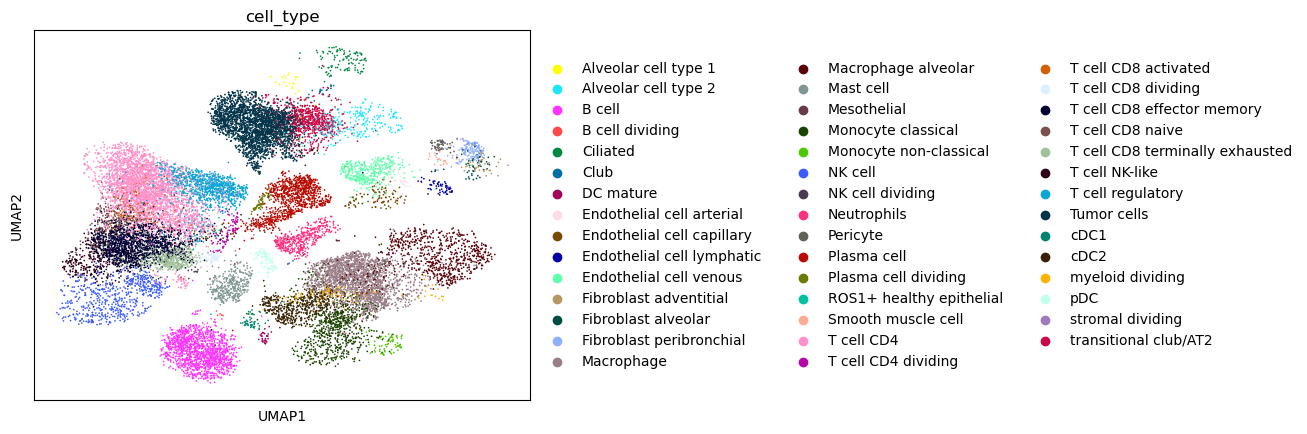

In [16]:
sc.pl.umap(adata_sc, color=["cell_type"])

In [19]:
adata_sc.obsm["cell_weights"]

,TCGA-05-4244,TCGA-05-4249,TCGA-05-4250,TCGA-05-4382,TCGA-05-4384,TCGA-05-4389,TCGA-05-4390,TCGA-05-4395,TCGA-05-4396,TCGA-05-4397,...,TCGA-NK-A5CX,TCGA-NK-A5D1,TCGA-NK-A7XE,TCGA-O2-A52N,TCGA-O2-A52Q,TCGA-O2-A52S,TCGA-O2-A52V,TCGA-O2-A52W,TCGA-O2-A5IB,TCGA-XC-AA0X
GTTCGGGTCTGAGGGA-1-34-8,0.0,0.0,0.000032,0.000010,0.0,0.000059,0.000026,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000015,0.00000,0.000000,0.0
TACTTACCATGTAGTC-1_7-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000022,0.000000,0.000021,0.000000,0.000000,0.000000,0.000000,0.00000,0.000024,0.0
GTGCAGCGTAGCAAAT-1_1-1,0.0,0.0,0.000068,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000129,0.000079,0.000000,0.00000,0.000000,0.0
CTACACCAGACACGAC-1-35-8,0.0,0.0,0.000000,0.000078,0.0,0.000000,0.000192,0.000000,0.000000,0.0,...,0.000070,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.00000,0.000000,0.0
528658_17-3,0.0,0.0,0.000000,0.000014,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000032,0.000053,0.000084,0.00000,0.000020,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34_GGCCGCATACGC-20,0.0,0.0,0.000065,0.000000,0.0,0.000000,0.000000,0.000102,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
bcHVCV_0-21,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000013,0.000000,0.000016,0.0,...,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
CATCAAGAGAGCTATA_LUNG_T31-5,0.0,0.0,0.000043,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
19_ACCTTTGAGAAC-20,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000145,0.000000,0.0,...,0.000332,0.000099,0.000189,0.000444,0.000363,0.000000,0.000196,0.00011,0.000066,0.0


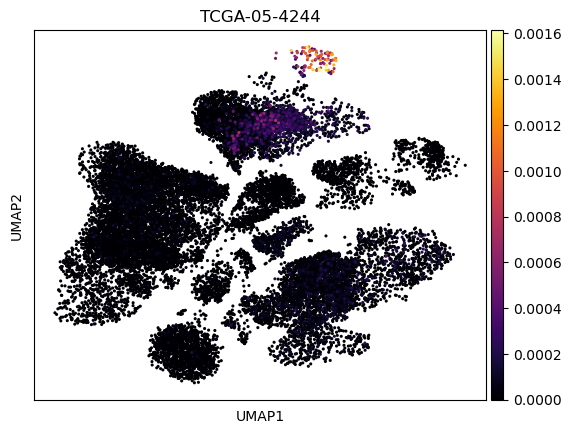

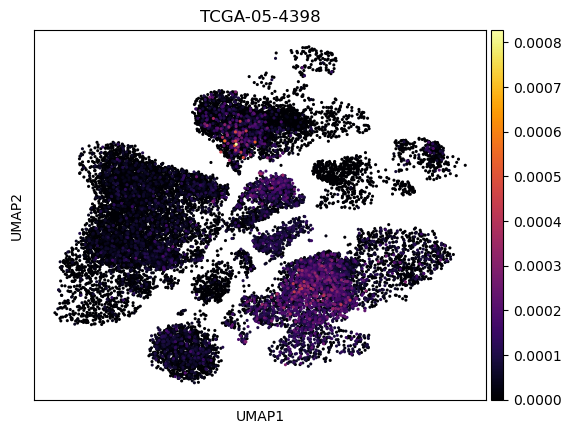

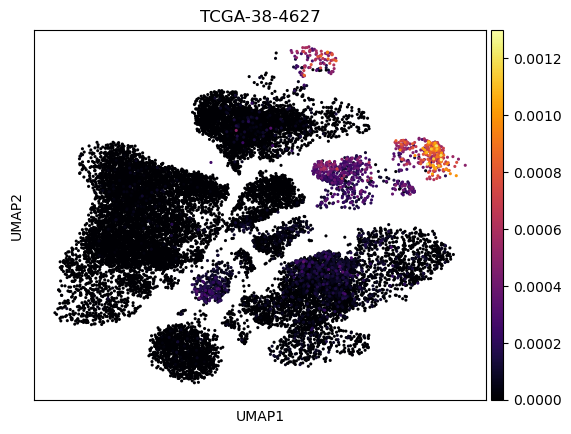

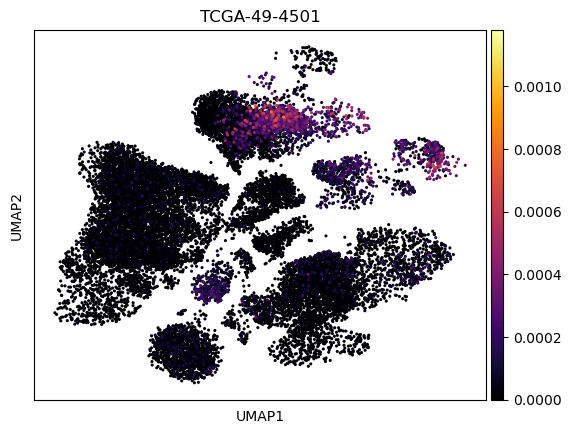

In [30]:
for p in adata_sc.obsm["cell_weights"].columns[np.array([0, 10, 40, 100])].tolist():
    adata_sc.obs[p] = adata_sc.obsm["cell_weights"][p]
    sc.pl.umap(adata_sc, color=p, cmap="inferno", size=20)

## Run shears (statistical analysis)

In [45]:
adata_tcga.obs

,time,status,ajcc_pathologic_tumor_stage,type,age_at_diagnosis,birth_days_to,gender,response_to_chemotherapy,tumor_stage_ajcc,age,tumor_stage,kras_mutation,braf_mutation,egfr_mutation,tp53_mutation,stk11_mutation,tumor_type,random,stk11_kras_mutation
TCGA-05-4244,0.0,0,Stage IV,LUAD,70.0,-25752.0,MALE,NaN,Stage IV,71.0,1.0,1,0,0,0,1,0,0,1
TCGA-05-4249,1523.0,0,Stage IB,LUAD,67.0,-24532.0,MALE,NaN,Stage I,67.0,0.0,1,1,0,0,0,0,0,0
TCGA-05-4250,121.0,1,Stage IIIA,LUAD,79.0,-29068.0,FEMALE,NaN,Stage III,80.0,1.0,1,0,0,0,0,0,0,0
TCGA-05-4382,607.0,0,Stage IB,LUAD,68.0,-24868.0,MALE,NaN,Stage I,68.0,0.0,0,1,1,1,0,0,0,0
TCGA-05-4384,426.0,0,Stage IIIA,LUAD,66.0,-24411.0,MALE,0.0,Stage III,67.0,1.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A52S,387.0,1,Stage III,LUSC,57.0,-21182.0,FEMALE,NaN,Stage III,58.0,1.0,0,0,0,0,0,1,1,0
TCGA-O2-A52V,1335.0,1,Stage II,LUSC,75.0,-27449.0,FEMALE,NaN,Stage II,75.0,0.0,0,0,0,1,0,1,0,0
TCGA-O2-A52W,261.0,1,Stage I,LUSC,63.0,-23156.0,MALE,NaN,Stage I,63.0,0.0,0,0,0,1,0,1,1,0
TCGA-O2-A5IB,340.0,1,Stage III,LUSC,71.0,-26211.0,FEMALE,NaN,Stage III,72.0,1.0,0,0,0,1,0,1,0,0


In [52]:
res = sh.tl.shears(adata_sc, adata_tcga, dep_var="C(tp53_mutation)", covariate_str=" + C(type) + C(tumor_stage_ajcc) + age_at_diagnosis", n_jobs=32)

100%|██████████| 20000/20000 [00:03<00:00, 6428.59it/s]  


In [58]:
adata_sc.obs["shears"] = res["coef"]
adata_sc.obs.loc[res["pvalue"] > 0.001, "shears"] = np.nan

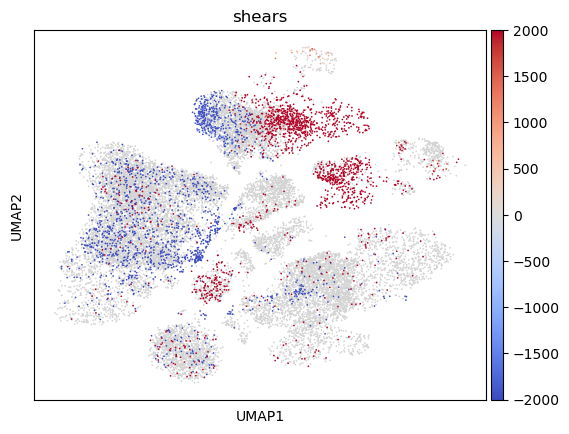

In [59]:
sc.pl.umap(adata_sc, color="shears", cmap="coolwarm", vmin=-2000, vmax=2000)

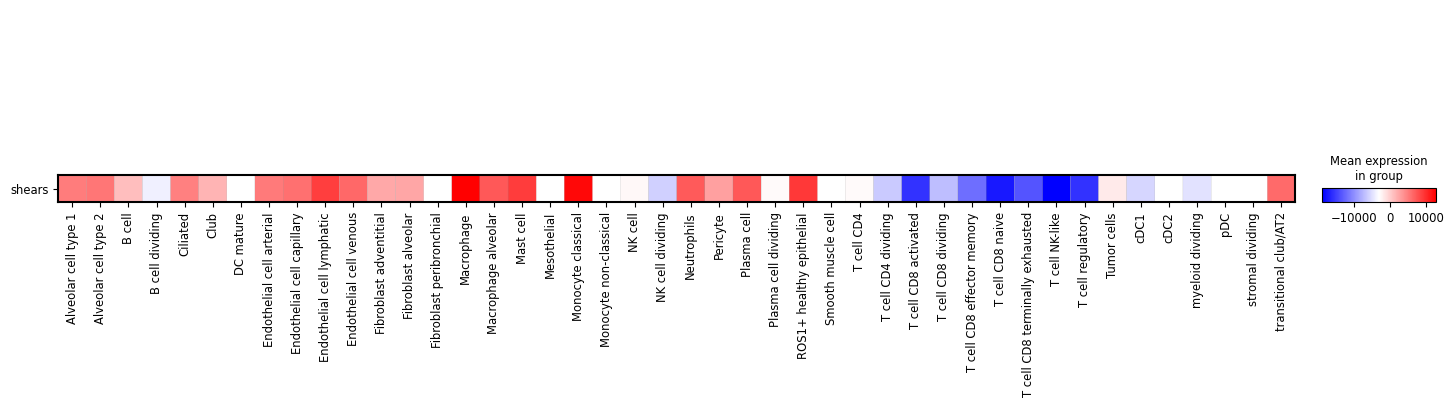

In [55]:
sc.pl.matrixplot(adata_sc, var_names="shears", groupby="cell_type", swap_axes=True, cmap="bwr")